In [170]:
import pandas as pd
import numpy as np
import os, shutil
import time
from time import sleep
from tqdm.notebook import trange, tqdm
import tensorflow as tf
import IPython.display as display
import functools
import keras
from keras import models
from keras.applications import inception_v3
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Load in Images

The data directories are comprised of the file path strings, one for each train, test, and split. Within the file paths are two folders. One folder has normal chest xray photos (no pneumonia) and another folder has chest xrays of people with pneumonia.

In [171]:
datadir_train = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/train'
datadir_test = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/test'
datadir_validate = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/val'
categories = ['NORMAL', 'PNEUMONIA']

# Data Augmentation

In [184]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_train, 
        batch_size = 5216,
        target_size=(256, 256), 
        seed = 123,
        class_mode="binary") 

Found 5216 images belonging to 2 classes.


In [173]:
data_test = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_test, 
        target_size=(256, 256), 
        batch_size = 624,
        seed = 123,
        class_mode="binary")
#         shuffle = False) 

Found 624 images belonging to 2 classes.


In [174]:
data_val = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_validate, 
        target_size=(256, 256), 
        seed = 12,
        class_mode="binary")
#         shuffle = False 

Found 16 images belonging to 2 classes.


# Images

In [185]:
train_images, train_labels = next(data_train)
test_images, test_labels = next(data_test)
val_images, val_labels = next(data_val)

In [187]:
train_labels[:100] 

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
      dtype=float32)

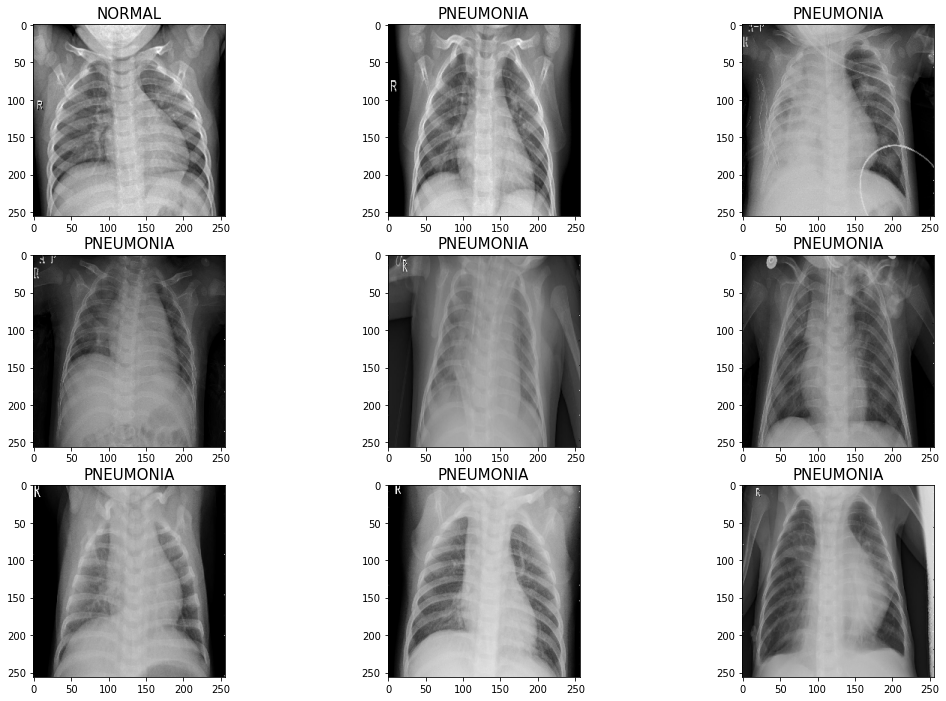

In [177]:
#visualize images
%matplotlib inline
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (18,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i])
    plt.title(categories[int(train_labels[i])], fontsize = 15)
plt.show()

# Modeling

## Model One - Feedforward Neural Network

In [188]:
X_train = np.array(train_images)
y_train = np.array(train_labels)

X_test = np.array(test_images)
y_test = np.array(test_labels)

X_val = np.array(val_images)
y_val = np.array(val_labels)

In [ ]:
# print(len(test_labels))
# print(y_test)

In [189]:
num_classes = 1

# specifying the model structure
model = Sequential()

#matching shape sizes
print(y_train.shape)
print(X_train.shape)

# specify the first hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# specify the second layer
model.add(Dense(64))
model.add(Dropout(0.2))

# specify the output layer
model.add(Dense(num_classes, activation='sigmoid'))

# model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

#history necessary for summary and evaluation
history = model.fit(X_train.flatten()[:len(y_train)], y_train,
                    batch_size= 1,
                    epochs=4,
                    verbose=1,
                    validation_data=(X_val.flatten()[:len(y_val)], y_val.flatten()))
score = model.evaluate(X_test.flatten()[:len(y_test)], y_test.flatten(), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(5216,)
(5216, 256, 256, 3)
Epoch 1/4
5216/5216 [==============================] - 10s 2ms/step - loss: 0.5676 - accuracy: 0.7525 - val_loss: 0.9147 - val_accuracy: 0.5000
Epoch 2/4
5216/5216 [==============================] - 11s 2ms/step - loss: 0.5745 - accuracy: 0.7435 - val_loss: 0.8454 - val_accuracy: 0.5000
Epoch 3/4
5216/5216 [==============================] - 15s 3ms/step - loss: 0.5834 - accuracy: 0.7318 - val_loss: 0.8447 - val_accuracy: 0.5000
Epoch 4/4
5216/5216 [==============================] - 14s 3ms/step - loss: 0.5760 - accuracy: 0.7394 - val_loss: 0.8405 - val_accuracy: 0.5000
Test loss: 0.7006970643997192
Test accuracy: 0.625


In [190]:
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['acc'] 
val_acc_values = history['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

## Model Two - CNN

In [125]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same')) #3 x 3 shape of filter, 64 convolutions
cnn.add(layers.MaxPooling2D((2, 2),padding='same')) #padding added so edge pixels get included in convolution
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same')) #hidden layer
cnn.add(layers.MaxPooling2D((2, 2),padding='same')) #max pooling
cnn.add(layers.Flatten()) #flatten layer
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.007),
              metrics=['acc', 'Recall', 'Precision']) #compiling with gradient descent

history = cnn.fit(data_train,
                epochs=5,
                batch_size=50,
                validation_data = data_val)

Epoch 1/5
163/163 [==============================] - 453s 3s/step - loss: 11.2084 - acc: 0.7827 - recall: 0.8799 - precision: 0.8340 - val_loss: 0.8103 - val_acc: 0.7500 - val_recall: 1.0000 - val_precision: 0.6667
Epoch 2/5
163/163 [==============================] - 446s 3s/step - loss: 0.2622 - acc: 0.8883 - recall: 0.9229 - precision: 0.9243 - val_loss: 0.5379 - val_acc: 0.8125 - val_recall: 1.0000 - val_precision: 0.7273
Epoch 3/5
163/163 [==============================] - 381s 2s/step - loss: 0.1523 - acc: 0.9390 - recall: 0.9617 - precision: 0.9559 - val_loss: 0.1890 - val_acc: 0.8750 - val_recall: 1.0000 - val_precision: 0.8000
Epoch 4/5
163/163 [==============================] - 453s 3s/step - loss: 0.1369 - acc: 0.9554 - recall: 0.9676 - precision: 0.9722 - val_loss: 2.8361 - val_acc: 0.6875 - val_recall: 1.0000 - val_precision: 0.6154
Epoch 5/5
163/163 [==============================] - 499s 3s/step - loss: 0.2773 - acc: 0.8575 - recall: 0.9430 - precision: 0.8746 - val_loss:

In [136]:
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4194336   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [137]:
results_train = cnn.evaluate(data_train)
results_test = cnn.evaluate(data_test)
print(results_train, results_test)

1/1 [==============================] - 25s 25s/step - loss: 2.2054 - acc: 0.7147 - recall: 0.9513 - precision: 0.7000
[0.21658508479595184, 0.8859279155731201, 0.961548388004303, 0.8930968642234802] [2.205411195755005, 0.7147436141967773, 0.9512820243835449, 0.699999988079071]


In [149]:
# pred

In [138]:
# y_test

array([1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1.

In [142]:
# y_test.shape

(624,)

In [143]:
# pred.shape

(624, 1)

In [147]:
#confusion matrix
pred = cnn.predict(X_test)
confusion_matrix(y_test, pred.round())

array([[ 75, 159],
       [ 19, 371]], dtype=int64)

In [61]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4194336   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [ ]:
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['acc'] 
val_acc_values = history['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model Three - CNN 

In [150]:
tic = time.time()
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same')) #3 x 3 shape of filter, 64 convolutions
cnn3.add(layers.AveragePooling2D((2, 2),padding='same'))
cnn3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn3.add(layers.AveragePooling2D((2, 2),padding='same'))
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(32, activation='relu'))
cnn3.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn3.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.002),
              metrics=['acc', 'Recall', 'Precision'])

In [151]:
history = cnn3.fit(data_train,
                    epochs=9,
                    batch_size=25,
                    validation_data=(data_val))
toc = time.time()
print('run time:', toc-tic)

Epoch 1/9
163/163 [==============================] - 729s 4s/step - loss: 0.5998 - acc: 0.8226 - recall: 0.9330 - precision: 0.8492 - val_loss: 0.1391 - val_acc: 0.9375 - val_recall: 1.0000 - val_precision: 0.8889
Epoch 2/9
163/163 [==============================] - 567s 3s/step - loss: 0.1397 - acc: 0.9462 - recall: 0.9626 - precision: 0.9655 - val_loss: 0.5518 - val_acc: 0.6875 - val_recall: 1.0000 - val_precision: 0.6154
Epoch 3/9
163/163 [==============================] - 472s 3s/step - loss: 0.1178 - acc: 0.9576 - recall: 0.9734 - precision: 0.9699 - val_loss: 0.0723 - val_acc: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/9
163/163 [==============================] - 455s 3s/step - loss: 0.0701 - acc: 0.9760 - recall: 0.9822 - precision: 0.9854 - val_loss: 0.2231 - val_acc: 0.8750 - val_recall: 1.0000 - val_precision: 0.8000
Epoch 5/9
163/163 [==============================] - 497s 3s/step - loss: 0.1436 - acc: 0.9507 - recall: 0.9689 - precision: 0.9650 - val_loss: 

In [152]:
cnn3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
average_pooling2d_8 (Average (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 126, 126, 32)      18464     
_________________________________________________________________
average_pooling2d_9 (Average (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4064288   
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

In [153]:
results_train3 = cnn3.evaluate(data_train)
results_test3 = cnn3.evaluate(data_test)
print(results_train3, results_test3)

1/1 [==============================] - 25s 25s/step - loss: 1.1321 - acc: 0.7564 - recall: 0.9897 - precision: 0.7228
[0.04186782240867615, 0.9861963391304016, 0.9860644936561584, 0.9953112602233887] [1.132129430770874, 0.7564102411270142, 0.9897435903549194, 0.7228464484214783]


In [155]:
#confusion matrix
pred3 = cnn3.predict(X_test)
confusion_matrix(y_test, pred3.round())

array([[ 86, 148],
       [  4, 386]], dtype=int64)

## Model Four - CNN

In [156]:
tic = time.time()
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same')) #3 x 3 shape of filter, 64 convolutions
cnn4.add(layers.MaxPooling2D((2, 2),padding='same'))
cnn4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn4.add(layers.AveragePooling2D((2, 2),padding='same'))
cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(32, activation='relu'))
cnn4.add(layers.Dropout(.5))
cnn4.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn4.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.002),
              metrics=['acc', 'Recall', 'Precision', 'AUC'])

history = cnn4.fit(X_train,
                y_train,
                epochs=5,
                batch_size=25,
                validation_data=(X_val, y_val))
toc = time.time()
print('run time:', toc-tic)

Epoch 1/5
2/2 [==============================] - 6s 2s/step - loss: 1.1901 - acc: 0.4325 - recall: 0.2593 - precision: 0.9259 - auc: 0.5233 - val_loss: 14.1954 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 2/5
2/2 [==============================] - 3s 969ms/step - loss: 19.3535 - acc: 0.3092 - recall: 0.1842 - precision: 0.6111 - auc: 0.4477 - val_loss: 1.0988 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000 - val_auc: 0.5391
Epoch 3/5
2/2 [==============================] - 3s 1s/step - loss: 0.7619 - acc: 0.6850 - recall: 0.9444 - precision: 0.7156 - auc: 0.4383 - val_loss: 1.3338 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000 - val_auc: 0.5781
Epoch 4/5
2/2 [==============================] - 3s 928ms/step - loss: 0.8370 - acc: 0.7400 - recall: 1.0000 - precision: 0.7400 - auc: 0.4067 - val_loss: 1.0086 - val_acc: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000 - val_auc: 0.6875
Epoch 5/5
2/2 [=========

In [157]:
cnn4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 126, 126, 32)      18464     
_________________________________________________________________
average_pooling2d_10 (Averag (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                4064288   
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)              

In [158]:
results_train = cnn4.evaluate(data_train)
results_test = cnn4.evaluate(data_test)
print(results_train, results_test)

1/1 [==============================] - 20s 20s/step - loss: 0.7044 - acc: 0.6250 - recall: 1.0000 - precision: 0.6250 - auc: 0.5780
[0.5591044425964355, 0.7429064512252808, 1.0, 0.7429064512252808, 0.621738612651825] [0.7043722867965698, 0.625, 1.0, 0.625, 0.578035295009613]


In [159]:
#confusion matrix
pred4 = cnn4.predict(X_test)
confusion_matrix(y_test, pred4.round())

array([[  0, 234],
       [  0, 390]], dtype=int64)

## Model 5 - InceptionV3

In [163]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
inception_model = models.Sequential()
inception_model.add(imagenet)
inception_model.add(GlobalAveragePooling2D())
inception_model.add(Dense(1024,activation='relu'))
inception_model.add(Dense(1024,activation='relu')) #dense layer 2
inception_model.add(Dense(512,activation='relu')) #dense layer 3
inception_model.add(Dense(1,activation='sigmoid')) #final layer with sigmoid activation

In [165]:
inception_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

# step_size_train=train_generator.n//train_generator.batch_size
inception_model.fit(data_train,
          epochs=6,
          batch_size=32,
          validation_data=(data_val))

Epoch 1/6
163/163 [==============================] - 2443s 15s/step - loss: 0.2214 - accuracy: 0.9305 - recall: 0.9734 - precision: 0.9386 - auc: 0.9548 - val_loss: 49.8371 - val_accuracy: 0.5000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 2/6
163/163 [==============================] - 2992s 18s/step - loss: 0.0862 - accuracy: 0.9728 - recall: 0.9850 - precision: 0.9784 - auc: 0.9928 - val_loss: 6.6414 - val_accuracy: 0.5000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5625
Epoch 3/6
163/163 [==============================] - 2990s 18s/step - loss: 0.0725 - accuracy: 0.9730 - recall: 0.9790 - precision: 0.9844 - auc: 0.9946 - val_loss: 0.0732 - val_accuracy: 0.9375 - val_recall: 1.0000 - val_precision: 0.8889 - val_auc: 1.0000
Epoch 4/6
163/163 [==============================] - 2027s 12s/step - loss: 0.0347 - accuracy: 0.9889 - recall: 0.9934 - precision: 0.9918 - auc: 0.9971 - val_loss: 2.8634 - val_accuracy: 0.5000 - val_recall: 

In [166]:
inception_model.evaluate(X_train)

1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0]

In [167]:
predictions_transfer = inception_model.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

In [168]:
#confusion matrix
pred5 = inception_model.predict(X_test)
confusion_matrix(y_test, pred5.round())

array([[153,  81],
       [  1, 389]], dtype=int64)